In [1]:
#%load_ext autoreload
#%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import datetime

import datatable as dt
import lightgbm as lgb

In [2]:
from fastai import *
from fastai.basic_train import *
from fastai.basic_data import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.train import *
from fastai.callback import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.layers import *
from fastai.tabular import * 


In [3]:
path = './'
TRAIN_FN = f'{path}train.feather'
TEST_FN  = f'{path}test.feather'

In [4]:
train_identity    = dt.fread(f'{path}train_identity.csv')
train_transaction = dt.fread(f'{path}train_transaction.csv')
train_identity.key = "TransactionID"
train = train_transaction[:, :, dt.join(train_identity)].to_pandas()
del train_identity, train_transaction

In [5]:
test_identity    = dt.fread(f'{path}test_identity.csv')
test_transaction = dt.fread(f'{path}test_transaction.csv')
test_identity.key = "TransactionID"
test = test_transaction[:, :, dt.join(test_identity)].to_pandas()
del test_identity, test_transaction

In [6]:
gc.collect()

34

try:
    assert False
    train = pd.read_feather(TRAIN_FN)
except:
    train_identity    = pd.read_csv(f'{path}train_identity.csv')
    train_transaction = pd.read_csv(f'{path}train_transaction.csv')
    train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
    train.to_feather(TRAIN_FN)
    del train_identity, train_transaction
    gc.collect()
    
try:
    assert False
    test = pd.read_feather(TEST_FN)
except:
    test_identity     = pd.read_csv(f'{path}test_identity.csv')
    test_transaction  = pd.read_csv(f'{path}test_transaction.csv')
    test  = pd.merge(test_transaction, test_identity,   on='TransactionID', how='left')
    test.to_feather(TEST_FN)
    del test_identity, test_transaction
    gc.collect()


In [7]:
n_train = len(train)

In [8]:
test.insert(1,'isFraud', -100)

In [9]:
test.insert(2, 'isTest', 1)
train.insert(2, 'isTest', 0)

In [10]:
test_ids = test['TransactionID']

In [11]:
df = pd.concat([train, test], ignore_index= True,axis=0, sort=False)
n_test = len(df) - n_train
del train, test
gc.collect()
n_train, n_test

(590540, 506691)

In [12]:
df.head()

,TransactionID,isFraud,isTest,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,0,86400,68.5,W,13926,NaN,150.0,discover,...,None,NaN,None,None,None,None,None,None,None,None
1,2987001,0,0,86401,29.0,W,2755,404.0,150.0,mastercard,...,None,NaN,None,None,None,None,None,None,None,None
2,2987002,0,0,86469,59.0,W,4663,490.0,150.0,visa,...,None,NaN,None,None,None,None,None,None,None,None
3,2987003,0,0,86499,50.0,W,18132,567.0,150.0,mastercard,...,None,NaN,None,None,None,None,None,None,None,None
4,2987004,0,0,86506,50.0,H,4497,514.0,150.0,mastercard,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


# Processing

In [13]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#579001
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

df['dow']   = df['TransactionDT'].dt.dayofweek
df['hour']  = df['TransactionDT'].dt.hour
df['day']   = df['TransactionDT'].dt.day

In [14]:
df = df.drop(['TransactionDT', 'TransactionID'], axis=1)

In [15]:
df['card1_count_full'] = df['card1'].map(df['card1'].value_counts(dropna=False))


In [16]:
df['P_emaildomain'] = df['P_emaildomain'].fillna('na')
df['R_emaildomain'] = df['R_emaildomain'].fillna('na')

In [17]:
df['TransactionAmt_decimals'] = df['TransactionAmt'].map(lambda x:len(str(x).split('.')[1]))

In [18]:
cat_names = list(set(df.columns) - set(df._get_numeric_data().columns))

In [19]:
procs = [FillMissing, Categorify, Normalize]


In [20]:
cont_names = list(np.setdiff1d(df.columns, cat_names + ['isFraud', 'isTest']))

In [21]:
def diff_train_test(c):
    df[c] = df[c].fillna('na')
    df.loc[df[c].isnull(), c] = 'na'

for c in progress_bar(cat_names): diff_train_test(c)

In [22]:
cat_names

['M8',
 'id_12',
 'DeviceType',
 'M1',
 'id_23',
 'id_15',
 'id_37',
 'M9',
 'card4',
 'id_33',
 'M7',
 'P_emaildomain',
 'M3',
 'id_36',
 'card6',
 'id_31',
 'id_29',
 'DeviceInfo',
 'id_16',
 'id_38',
 'ProductCD',
 'id_34',
 'id_27',
 'M2',
 'M6',
 'R_emaildomain',
 'M5',
 'id_35',
 'id_28',
 'id_30',
 'M4']

In [23]:
df['DeviceInfo'].value_counts()

na                      811091
Windows                  92710
                         52417
iOS Device               38502
MacOS                    23722
                         ...  
Mobiistar_LAI_Yuna_X         1
DLI-L22                      1
Azumi_KINZO_A5_QL            1
Azumi_DOSHI_A55_QL           1
A462C                        1
Name: DeviceInfo, Length: 2801, dtype: int64

In [24]:
min_threshold = 0.01

def frequency_encoding(c):
    encoding = df.groupby(c).size()/len(df)
    return df[c].map(encoding)
for c in progress_bar(np.setdiff1d(cat_names,['dow_freq','hour_freq','day_freq'])):
    freq = frequency_encoding(c)
    df[f"{c}_freq"] = freq
    cont_names.append(f"{c}_freq")
    df[c][(freq <= min_threshold)] = f'm_{min_threshold}'

/home/antor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [25]:
df['DeviceInfo'].value_counts()

na             811091
Windows         92710
m_0.01          66459
                52417
iOS Device      38502
MacOS           23722
Trident/7.0     12330
Name: DeviceInfo, dtype: int64

In [26]:
for c in progress_bar(cat_names):
    df[c] = df[c].astype('category').cat.codes

# LGB

In [ ]:
train_idx = range(int(n_train*.8))
valid_idx = list(np.setdiff1d(range(n_train), train_idx))

In [ ]:
trn_data = lgb.Dataset(df.iloc[train_idx][cont_names + cat_names], label=df.iloc[train_idx]['isFraud'],
                      categorical_feature = cat_names)
val_data = lgb.Dataset(df.iloc[valid_idx][cont_names + cat_names], label=df.iloc[valid_idx]['isFraud'],
                      categorical_feature = cat_names)
#clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)


In [ ]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }


In [ ]:
clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], 
                verbose_eval=1000, early_stopping_rounds=500)


# Tabular NN

In [ ]:
for c in progress_bar(cat_names):
    df[c] = df[c].astype('category')

In [ ]:
for c in cont_names:
    print(c, pd.isna(df[c]))

In [ ]:
data = TabularDataBunch.from_df(path, df[:n_train], dep_var, cat_names=cat_names, 
                                cont_names =cont_names,
                                valid_idx=valid_idx, 
                                procs=[Normalize, FillMissing, Categorify])

In [ ]:
data.batch_size = 4096*8

In [ ]:
learn = tabular_learner(
    data, layers=[512]*32,
    ps=0.3,metrics=[accuracy, AUROC()], callback_fns=ShowGraph, use_bn=True)


In [ ]:
learn.summary()

In [ ]:
learn.model

In [ ]:
weight = Tensor(n_train / (2 * np.bincount(df['isFraud'][:n_train].values)))
learn.loss_func.weight=weight

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10,5.75e-3)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.reduction = reduction

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.reduction == 'mean': return loss.mean()
        else: return loss

In [ ]:
class ThresholdLoss(Module):
    def __init__(self, pct=0.2, weight=None): 
        self.pct = pct
        self.loss = FocalLoss(reduction='none')
#        self.loss = nn.CrossEntropyLoss(weight=weight.cuda(),reduction='none')
    def forward(self, from_forward, t_fraud):
        p_fraud = from_forward
        loss = self.loss(p_fraud, t_fraud)
        threshold = loss.topk(int(self.pct*len(t_fraud)))[0][-1]
        loss[loss < threshold] == 0.
        return loss.mean()

In [ ]:
learn.loss_func = FocalLoss() #ThresholdLoss(weight=weight)

In [ ]:
learn.callbacks.append(ReduceLROnPlateauCallback(learn, monitor="train_loss", patience=2))

In [ ]:
learn.fit(1000,1.2e-2)

In [ ]:
preds,y,losses = learn.get_preds(DatasetType.Fix,with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.top_losses(40000)

In [ ]:
import seaborn as sns

In [ ]:
sns.distplot(losses)

In [ ]:
interp.top_losses(len(preds))

# Autoencoder

In [27]:
from fastai.tabular.transform import *

In [28]:
cont_names

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'TransactionAmt',
 'TransactionAmt_decimals',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V17',
 'V170',
 'V171',
 'V172',
 'V173',
 '

In [29]:
#cont_names = list(np.setdiff1d(cont_names, [c for c in cont_names if c.startswith('V')]))

In [30]:
#cat_names = list(np.setdiff1d(cat_names, ['DeviceInfo', 'DeviceType']))

In [31]:
c = Categorify(cat_names, cont_names)
c.apply_train(df)

In [32]:
c = FillMissing(cat_names, cont_names)
c.apply_train(df)

In [37]:
na_columns = [c for c in df.columns if c.endswith('_na')]
cont_names.extend(na_columns)
cat_names = list(np.setdiff1d(cat_names, na_columns))

In [38]:
cont_names

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'TransactionAmt',
 'TransactionAmt_decimals',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V17',
 'V170',
 'V171',
 'V172',
 'V173',
 '

In [39]:
cat_names

['DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'card4',
 'card6',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

In [60]:
cats = [LongTensor(df[cat_name].cat.codes.values) for cat_name in cat_names]
cats = torch.cat([cat.unsqueeze(-1) for cat in cats], dim=-1)

In [61]:
cats

tensor([[6, 3, 1,  ..., 2, 3, 3],
        [6, 3, 0,  ..., 2, 3, 3],
        [6, 3, 1,  ..., 2, 3, 3],
        ...,
        [6, 3, 1,  ..., 2, 3, 3],
        [6, 3, 1,  ..., 2, 3, 3],
        [5, 2, 0,  ..., 0, 1, 0]])

In [62]:
conts = [Tensor(df[cont_name].values) for cont_name in cont_names]
conts

[tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 1.]),
 tensor([2., 1., 1.,  ..., 1., 1., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 1.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 1.]),
 tensor([0., 0., 0.,  ..., 0., 0., 1.]),
 tensor([1., 0., 1.,  ..., 1., 1., 0.]),
 tensor([14.,  0.,  0.,  ...,  0.,  0.,  0.]),
 tensor([13.,  0.,  0.,  ...,  0.,  0.,  0.]),
 tensor([ 13.,  69., 315.,  ...,   0.,   0.,  69.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([  0.,   0., 315.,  ...,   0.,   0.,   0.]),
 tensor([104., 104., 104.,  ..., 104., 104., 104.]),
 tensor([13.,  8.,  8.,  ...,  8.,  8.,  8.]),
 te

In [74]:
conts = [Tensor(df[cont_name].values) for cont_name in progress_bar(cont_names)]
#conts = [torch.log1p(Tensor(df[cont_name].values-df[cont_name].min())) for cont_name in cont_names]
#for cont in conts: cont[cont!=cont] = -100 # turn NaNs into -1
conts = torch.cat([cont.unsqueeze(-1) for cont in conts], dim=-1)

In [75]:
conts.shape

torch.Size([1097231, 1232])

In [76]:
conts_mean, conts_std = conts.mean(dim=0), conts.std(dim=0)
conts_mean, conts_std

(tensor([12.2456,  3.6563,  8.9684,  ...,  0.9907,  0.9907,  0.8649]),
 tensor([1.1186e+02, 7.1966e+01, 8.0797e+01,  ..., 9.5832e-02, 9.6014e-02,
         3.4185e-01]))

In [77]:
conts = (conts - conts_mean) / conts_std

In [78]:
class TransactionItem(ItemBase):
    def __init__(self,i): self.i = i
    @property
    def data(self):
        return cats[self.i], conts[self.i]
    def __str__(self): return f'{self.i}'
    
    def apply_tfms(self, tfms:Collection, **kwargs):
        x = self.clone()
        for t in tfms:
            if t: x.data = t(x.data)
        return x
    
    def clone(self):
        return self.__class__(self.i)
    
    def reconstruct(self, t:Tensor, x:Tensor=None):
        return t

class TransactionItemList(ItemList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)

    def get(self, i):
        return super().get(i)

    def reconstruct(self,t): return 0; # TODO

In [79]:
conts.shape

torch.Size([1097231, 1232])

In [80]:
data = ItemList(items=(TransactionItem(i) for i in range(conts.shape[0])))#,label_cls=TransactionItem)

In [81]:
train_idx = list(range(int(n_train*.8))) + list(range(n_train, n_train + int(n_test*0.8)))
valid_idx = list(np.setdiff1d(range(n_train+n_test), train_idx))

In [82]:
data = data.split_by_idxs(train_idx, valid_idx)

In [83]:
#data = data.label_from_func(func=lambda x:x,label_cls=TransactionItemList)
#data = data.label_from_lists(df[['isFraud', 'isTest']].values[train_idx], df[['isFraud', 'isTest']].values[valid_idx])
data = data.label_from_lists(df['isTest'].values[train_idx], df['isTest'].values[valid_idx])

In [84]:
data=data.databunch()

In [85]:
data.add_test(ItemList(items=(TransactionItem(i) for i in range(n_train+n_test))))

In [86]:
data

DataBunch;

Train: LabelList (877784 items)
x: ItemList
0,1,2,3,4
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (219447 items)
x: ItemList
472432,472433,472434,472435,472436
y: CategoryList
0,0,0,0,0
Path: .;

Test: LabelList (1097231 items)
x: ItemList
0,1,2,3,4
y: EmptyLabelList
,,,,
Path: .

## Model

In [87]:
def emb_sz_rule(n_cat:int)->int: return min(50, (n_cat//2)+1)
flatten = lambda l: [item for sublist in l for item in sublist]

class TransactionAutoencoder(Module):
    def __init__(self, cat_names, cont_names,encoder_layers,decoder_layers=None):
        self.cat_names, self.cont_names = cat_names, cont_names
        self.cats_nunique  = cats.max(dim=0)[0]+1
        self.cat_embs = nn.ModuleList(
            [nn.Embedding(cat_nunique,emb_sz_rule(cat_nunique)) for cat_nunique in self.cats_nunique])
        self.emb_total_dim = sum([emb_sz_rule(cat_nunique) for cat_nunique in self.cats_nunique])
        self.cont_total_dim = conts.shape[1]
        decoder_layers=ifnone(decoder_layers, encoder_layers[::-1])
        encoder_layers.insert( 0,int(self.cont_total_dim + self.emb_total_dim))
        decoder_layers.append(int(self.cont_total_dim + self.cats_nunique.sum()))
        self.encoder = nn.Sequential(
            *flatten([[nn.Linear(encoder_layers[i],encoder_layers[i+1]),nn.ReLU(), nn.BatchNorm1d(encoder_layers[i+1])]
              for i in range(len(encoder_layers)-1)])[:])
        self.decoder = nn.Sequential(
            *flatten([[nn.Linear(decoder_layers[i],decoder_layers[i+1]),nn.ReLU(), nn.BatchNorm1d(decoder_layers[i+1])]
              for i in range(len(decoder_layers)-1)])[:-2])
        
        
        self.is_test = nn.Sequential(
            *flatten([[nn.Linear(int(2**i),int(2**(i-1))),nn.ReLU(), nn.BatchNorm1d(int(2**(i-1)))]
              for i in range(int(np.log2(encoder_layers[-1])),2,-1)]), nn.Linear(4,2))

    def forward(self,x_cats,x_conts):
        _x_cats = [x_cats[:,i] for i in range(x_cats.shape[1])]
        x = torch.cat([cat_emb(cat) for cat_emb,cat in zip(self.cat_embs, _x_cats)], dim=-1)
        x = torch.cat([x, x_conts], dim=-1)
        latent = self.encoder(x)
        x = self.decoder(latent)
        is_test = self.is_test(latent)
        return x_cats,x_conts, x[:,:self.cats_nunique.sum()],x[:,self.cats_nunique.sum():],is_test,latent

In [143]:
class ReconstructionLoss(Module):
    def __init__(self, cats_nunique):
        self.cats_nunique = cats_nunique

    def forward(self, from_forward, t_is_test):
        t_cats, t_conts, p_cats, p_conts, p_is_test, p_latent = from_forward
        cat_loss = 0
        s_hot = e_hot = 0
        for i, n_hot in enumerate(self.cats_nunique):
            e_hot = s_hot + n_hot
            cat_loss += nn.CrossEntropyLoss()(p_cats[:,s_hot:e_hot], t_cats[:,i])
            s_hot = e_hot
        cat_loss /= i
        cont_loss = nn.MSELoss()(p_conts, t_conts)
        adversarial_loss = nn.CrossEntropyLoss()(p_is_test, t_is_test)
        return 30*cat_loss + cont_loss #+ adversarial_loss

In [144]:
d_latent = 64

In [145]:
torch.manual_seed(0)
net, learner = None,None
gc.collect()
torch.cuda.empty_cache()

encoder_layers=[512,256,128,d_latent]
decoder_layers=encoder_layers[::-1]
net = TransactionAutoencoder(cat_names, cont_names,encoder_layers,decoder_layers)
learner = Learner(data,net,loss_func=ReconstructionLoss(net.cats_nunique),callback_fns=ShowGraph).to_fp32()

In [146]:
learner

Learner(data=DataBunch;

Train: LabelList (877784 items)
x: ItemList
0,1,2,3,4
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (219447 items)
x: ItemList
472432,472433,472434,472435,472436
y: CategoryList
0,0,0,0,0
Path: .;

Test: LabelList (1097231 items)
x: ItemList
0,1,2,3,4
y: EmptyLabelList
,,,,
Path: ., model=TransactionAutoencoder(
  (cat_embs): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(4, 3)
    (2): Embedding(3, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(4, 3)
    (6): Embedding(3, 2)
    (7): Embedding(3, 2)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(9, 5)
    (12): Embedding(5, 3)
    (13): Embedding(6, 4)
    (14): Embedding(4, 3)
    (15): Embedding(3, 2)
    (16): Embedding(3, 2)
    (17): Embedding(5, 3)
    (18): Embedding(4, 3)
    (19): Embedding(3, 2)
    (20): Embedding(3, 2)
    (21): Embedding(4, 3)
    (22): Embedding(4, 3)
    (23): Embedding(5, 3)
    (24): Embe

In [147]:
learner.summary()

TransactionAutoencoder
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [4]                  28         True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [2]                  6          True      
______________________________________________________________________
Embedding            [2]                  6          True      
______________________________________________________________________
Embedding            [2]                  6          True      
______________________________________________________________________
Embedding            [3]                  12         True      
______________________________________________________________________
Embedding            [2]                  6          True      
_______________________________________

In [148]:
learner.model

TransactionAutoencoder(
  (cat_embs): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(4, 3)
    (2): Embedding(3, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(4, 3)
    (6): Embedding(3, 2)
    (7): Embedding(3, 2)
    (8): Embedding(3, 2)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(9, 5)
    (12): Embedding(5, 3)
    (13): Embedding(6, 4)
    (14): Embedding(4, 3)
    (15): Embedding(3, 2)
    (16): Embedding(3, 2)
    (17): Embedding(5, 3)
    (18): Embedding(4, 3)
    (19): Embedding(3, 2)
    (20): Embedding(3, 2)
    (21): Embedding(4, 3)
    (22): Embedding(4, 3)
    (23): Embedding(5, 3)
    (24): Embedding(8, 5)
    (25): Embedding(6, 4)
    (26): Embedding(5, 3)
    (27): Embedding(4, 3)
    (28): Embedding(3, 2)
    (29): Embedding(4, 3)
    (30): Embedding(4, 3)
  )
  (encoder): Sequential(
    (0): Linear(in_features=1319, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=

In [149]:
data.batch_size = 4096*8

In [150]:
#autoencoder_fname = 'autoencoder_loss0.0008val0.0010'

In [151]:
loaded = False
try:
    learner.load(autoencoder_fname, strict=False)
    loaded = True
except Exception as e:
    print(e)

name 'autoencoder_fname' is not defined


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 6.92E-03


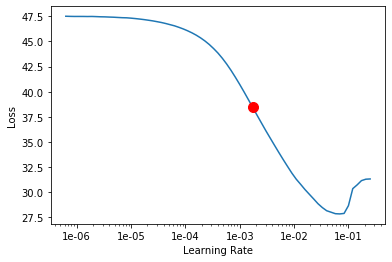

In [152]:
if not loaded:
    learner.lr_find()
    learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,time
0,35.946514,29.293501,00:13
1,23.184576,12.820310,00:13
2,15.225582,7.752847,00:13
3,10.076923,5.155647,00:13
4,6.741526,3.197262,00:13
5,4.473769,2.052161,00:13
6,2.987906,1.484996,00:13
7,2.025873,1.257626,00:13
8,1.404331,1.088914,00:13
9,1.003986,0.948122,00:13


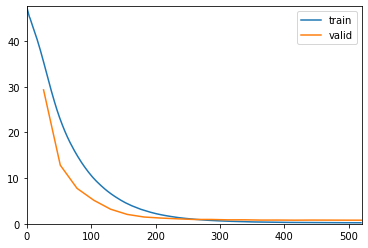

In [153]:
if not loaded: learner.fit_one_cycle(20,2e-3)

In [154]:
val = learner.validate()[0]
val

0.7907553

In [ ]:
if not loaded:
    try:
        autoencoder_fname = f'autoencoder_loss{learner.recorder.losses[-1]:.04f}val{val:.04f}'
    except:
        autoencoder_fname = f'autoencoder_lossval{val:.04f}'
    learner.save(autoencoder_fname)
    print(autoencoder_fname)

In [155]:
learner.data.fix_dl.batch_size = data.batch_size

In [156]:
def get_latents(ds_type):
    latents = torch.empty(0,d_latent)
    for batch_idx, batch in progress_bar(
        enumerate(learner.dl(ds_type)), total=len(learner.dl(ds_type))):
            t_cats, t_conts, p_cats, p_conts, p_is_test, p_latent = learner.pred_batch(ds_type=ds_type, batch=batch)
            latents = torch.cat([latents, p_latent], dim = 0)
    return latents
            
all_latents  = get_latents(DatasetType.Test)
latents      = all_latents[:n_train]
latents_test = all_latents[n_train:]

In [157]:
latents.shape

torch.Size([590540, 64])

In [158]:
n_train

590540

In [159]:
latents.shape

torch.Size([590540, 64])

In [160]:
df_latent = pd.DataFrame({**{'isFraud': df['isFraud'][:n_train].values.astype(np.int32)},
                          **{f'l_{i}' : latents[:,i].cpu().numpy().T for i in range(d_latent)}})

In [161]:
df_latent_test = pd.DataFrame({**{f'l_{i}' : latents_test[:,i].cpu().numpy().T for i in range(d_latent)}})

# Classifier

In [162]:
train_idx = range(int(n_train*.8))
valid_idx = list(np.setdiff1d(range(n_train), train_idx))

In [163]:
df_latent.iloc[train_idx]['isFraud']

0         0
1         0
2         0
3         0
4         0
         ..
472427    0
472428    0
472429    0
472430    0
472431    0
Name: isFraud, Length: 472432, dtype: int32

In [164]:
df_latent.loc[train_idx,df_latent.columns != 'isFraud']

,l_0,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_54,l_55,l_56,l_57,l_58,l_59,l_60,l_61,l_62,l_63
0,1.609179,-0.195527,-0.105292,-0.611569,-0.309707,-1.138371,-0.464352,-0.560705,-0.644472,-0.391171,...,-0.509150,-0.749603,-0.513325,2.290798,-0.500395,-0.592811,1.133883,-0.618048,0.014759,-0.556857
1,0.536446,-0.056623,1.901735,-0.611569,-0.826007,-1.138371,-0.464352,-0.560705,1.516381,-0.514663,...,-0.509150,-0.749603,-0.463647,-0.920896,-0.500395,-0.592811,2.099545,-0.618048,0.743241,-0.556857
2,-0.087067,-0.690702,-0.464052,-0.611569,-0.255664,-0.621156,-0.464352,-0.560705,-0.644472,-0.514663,...,-0.509150,-0.335764,-0.513325,0.913942,-0.500395,-0.592811,0.247482,-0.618048,0.419852,-0.556857
3,0.671915,-0.058674,1.915679,-0.611569,-0.826007,-1.138371,-0.464352,-0.560705,1.166618,-0.514663,...,-0.509150,-0.749603,-0.513325,-0.836539,-0.500395,-0.592811,2.201424,-0.618048,0.908551,-0.556857
4,-1.187679,0.788680,-0.464052,1.213443,3.273848,1.116109,2.519453,1.404840,1.413893,1.080059,...,1.185768,-0.749603,1.389232,-1.098345,2.345746,0.499470,-1.232385,1.436681,-0.840590,1.074411
5,0.495652,-0.690702,-0.464052,-0.611569,-0.207343,-0.124450,-0.464352,-0.560705,-0.644472,-0.514663,...,-0.509150,-0.338953,-0.513325,-0.039480,-0.500395,-0.592811,0.228217,-0.618048,0.059690,-0.556857
6,0.237800,-0.690702,-0.464052,-0.611569,-0.353540,0.012927,-0.464352,-0.560705,-0.644472,-0.514663,...,-0.509150,-0.350993,-0.513325,-0.004325,-0.500395,-0.592811,0.018839,-0.618048,0.387507,-0.556857
7,-0.439003,-0.278593,1.590646,-0.611569,-0.826007,-1.138371,-0.464352,-0.560705,1.049899,-0.514663,...,-0.509150,-0.749603,-0.513325,-0.164416,-0.500395,-0.592811,2.144663,-0.618048,0.935095,-0.556857
8,-1.187679,1.577858,-0.464052,0.581762,3.125286,0.447913,2.764018,0.826874,0.693522,1.689709,...,1.288719,-0.749603,1.555423,-1.098345,2.771149,0.467356,-1.232385,1.396906,-0.840590,1.796146
9,1.230840,-0.690702,-0.262895,-0.611569,-0.677134,-0.333708,-0.464352,-0.560705,-0.644472,-0.514663,...,-0.509150,-0.089756,-0.513325,0.334646,-0.500395,-0.592811,0.470194,-0.618048,0.617859,-0.556857


In [165]:
trn_data=lgb.Dataset(df_latent.loc[train_idx,df_latent.columns!='isFraud'], label=df_latent.iloc[train_idx]['isFraud'])
val_data=lgb.Dataset(df_latent.loc[valid_idx,df_latent.columns!='isFraud'], label=df_latent.iloc[valid_idx]['isFraud'])

In [166]:
cont_names

['C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'TransactionAmt',
 'TransactionAmt_decimals',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V16',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V17',
 'V170',
 'V171',
 'V172',
 'V173',
 '

In [167]:
df['P_emaildomain']

0          0
1          4
2          7
3          8
4          4
          ..
1097226    4
1097227    5
1097228    5
1097229    5
1097230    5
Name: P_emaildomain, Length: 1097231, dtype: category
Categories (9, int64): [0 < 1 < 2 < 3 ... 5 < 6 < 7 < 8]

In [169]:
params = {'num_leaves': 500,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

params = {'num_leaves': 500,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
         }

clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], 
                verbose_eval=100, early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.907658	valid_1's auc: 0.828865
[200]	training's auc: 0.933838	valid_1's auc: 0.838053
[300]	training's auc: 0.954901	valid_1's auc: 0.842877
[400]	training's auc: 0.969734	valid_1's auc: 0.843728
[500]	training's auc: 0.978241	valid_1's auc: 0.842807
[600]	training's auc: 0.98403	valid_1's auc: 0.843003


KeyboardInterrupt: 

# Predictions

In [ ]:
df_latent_test.shape

In [ ]:
learn.data.add_test(TabularList.from_df(df_latent_test, cat_names=None))

In [ ]:
learn.data

In [ ]:
preds = learn.get_preds(DatasetType.Test)

In [ ]:
len(preds[0])

In [ ]:
sub_df = pd.DataFrame({'TransactionID' : test_ids, 'isFraud' : preds[0][:,1]})
sub_df.head()

In [ ]:
csv_fname = f'cv{cv}.csv'
sub_df.to_csv(csv_fname, index=False)

In [ ]:
comp = 'ieee-fraud-detection'
!kaggle competitions submit -c {comp} -f {csv_fname} -m '{cv}'